In [ ]:

# build_datasets_2d.py  —— 8 qubits → 2×4 网格的 2D‑Ising 采样
import numpy as np, pandas as pd, itertools, os, random
from pathlib import Path

# ---------- 参数 ----------
n_qubits  = 8              # 2×4
shape     = (2, 4)
beta, J   = 0.7, 1.0
n_samples = 3_000
rng       = np.random.default_rng(0)
save_path = Path("../data_2d")

# ---------- 1. 生成所有 256 个比特串 ----------
bits256 = np.array(list(itertools.product([0, 1], repeat=n_qubits)))  # (256,8)
spins   = 2*bits256 - 1                                              # {-1,+1}

# ---------- 2. 2D Ising 能量 ----------
# 将线性索引 → (row,col)
def idx2rc(idx, shape):
    r, c = divmod(idx, shape[1]); return r, c

nbrs = [[] for _ in range(n_qubits)]
for i in range(n_qubits):
    r, c = idx2rc(i, shape)
    if r+1 < shape[0]:  nbrs[i].append(i + shape[1])   # ↓ neighbour
    if c+1 < shape[1]:  nbrs[i].append(i + 1)          # → neighbour
    # 若想周期边界，额外再加 (r-1) 和 (c-1) 的邻居

def E2d(s):
    e = 0.0
    for i in range(n_qubits):
        for j in nbrs[i]:
            e -= J * s[i] * s[j]
    return e

E = np.array([E2d(s) for s in spins])
p_unnorm = np.exp(-beta*E); p_unnorm /= p_unnorm.sum()

# ---------- 3. Boltzmann 采样 3000 条 ----------
sample_idx = rng.choice(256, size=n_samples, p=p_unnorm)
rows       = bits256[sample_idx]

# ---------- 4. 900‑900‑2100 分层抽样 ----------
all_idx = rng.permutation(n_samples)

train_idx  = all_idx[:900]
unseen_idx = all_idx[900:1800]
test_idx   = rng.choice(n_samples, size=2100, replace=False)

def to_df(sub_idx):
    df = pd.DataFrame(rows[sub_idx], columns=[f"q{i}" for i in range(n_qubits)])
    df["bitstring"] = df.astype(str).agg("".join, axis=1)
    return df

train_df  = to_df(train_idx)
unseen_df = to_df(unseen_idx)
test_df   = to_df(test_idx)

# ---------- 5. 保存 ----------
save_path.mkdir(parents=True, exist_ok=True)
train_df.to_csv(save_path/"train.csv",  index=False)
test_df.to_csv( save_path/"test.csv",   index=False)
unseen_df.to_csv(save_path/"unseen.csv", index=False)

print("train / unseen / test = ", len(train_df), len(unseen_df), len(test_df))


train / unseen / test =  900 900 2100


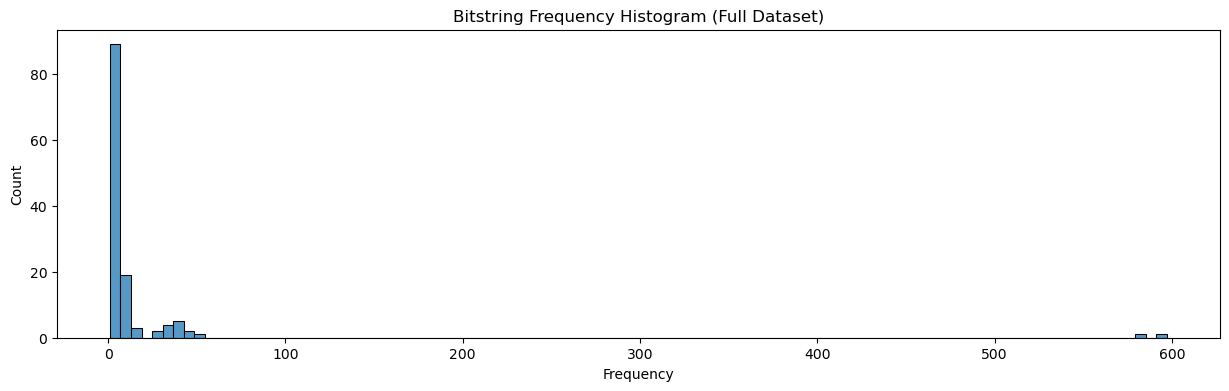

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
save_path = Path("../data_2d/test.csv")
df = pd.read_csv(save_path)
freq = df['bitstring'].value_counts()
plt.figure(figsize=(15, 4))
sns.histplot(freq.values, bins=100)
plt.title("Bitstring Frequency Histogram (Full Dataset)")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.show()
